# Business Case Data Analysis

This stage of the project is dedicated to Data Analysis for the purpose of gaining insights relevant to the following business case questions:

- What businesses are getting top reviews?
- Which categories of businesses are getting top reviews?
- How often do businesses get reviewed over time?
- How do the categories of trending and top reviewed businesses differ?
- Which business categories get bad reviews?
- What are the most common words in bad reviews? 


The structure of this notebook is organized as follows:

<ul>
    <li>1. Imports</li>
    <li>2. Data</li>
    <li>3. Business Case Data Analysis</li>
        <ul>
            <li>3.1 What businesses are getting top reviews?</li>
            <li>3.2 Which categories of businesses are getting top reviews?</li>
            <li>3.3 How often do businesses get reviewed over time?</li>
            <li>3.4 How do the categories of trending and top reviewed businesses differ?</li>
            <li>3.5 Which business categories get bad reviews?</li>
            <li>3.6 What are the most common words in bad reviews? </li>
        </ul>
</ul>

# Imports

In [1]:
#basic libraries for linear algebra and data procesing
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#text analysis
import spacy

#time and warnings
import time
import warnings

#settings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_context('poster', font_scale=0.5)

# Data

In [2]:
#loading the datasets

business = pd.read_csv('data/business_prepared.csv')
review = pd.read_csv('data/review_prepared.csv')
user = pd.read_csv('data/user_prepared.csv')

# Business Case Data Analysis


### Counting reviews

There are several types of reviews in the dataset, like useful reviews, cool reviews, and funny reviews. I would add positive (business stars >= 4), neutral (business stars = 3), and negative reviews (business stars <= 2):

In [3]:
print('Total number of reviews: ', len(review))
print('Positive reviews: ', len(review[review['stars'] >= 4]))
print('Neutral reviews: ', len(review[review['stars'] == 3]))
print('Negative reviews: ', len(review[review['stars'] <= 2]))
print('Useful reviews: ', len(review[review['useful'] > 0]))
print('Cool reviews: ', len(review[review['cool'] > 0]))
print('Funny reviews: ', len(review[review['funny'] > 0]))

Total number of reviews:  229130
Positive reviews:  155617
Neutral reviews:  35268
Negative reviews:  38245
Useful reviews:  134110
Cool reviews:  85432
Funny reviews:  68181


## 3.1 What businesses are getting top reviews?

Top three rated businesses are:
1. Pizzeria Bianco (stars: 4.0) with 803 reviews
2. Four Peaks Brewing Co (stars: 4.5) with 735 reviews 
3. Matt's Big Breakfast (stars: 4.0) with 689 reviews.

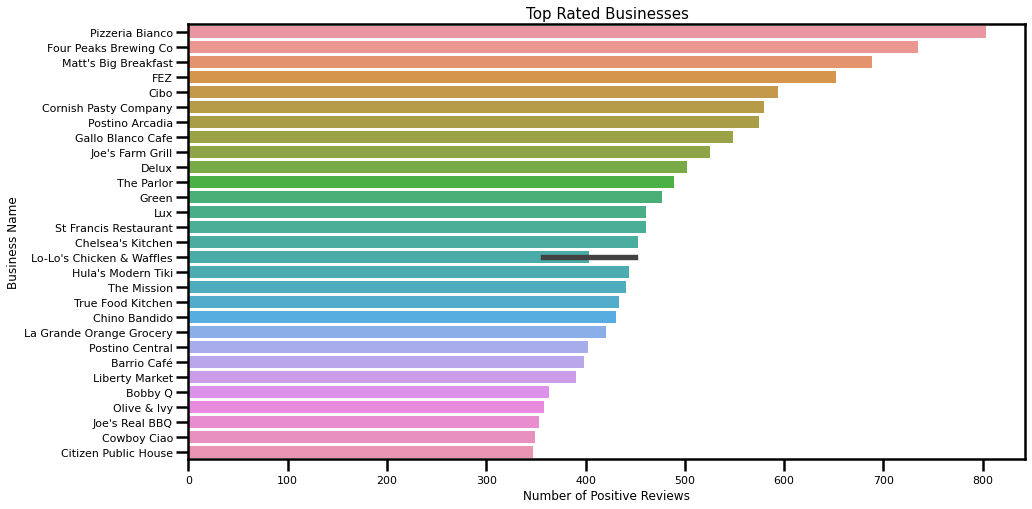

In [4]:
#creating a new dataframe that contains top 30 rated business sorted by the number of positive reviews
biz_good_rating = business[(business['business_stars'] >= 4) & (business['business_review_count'] > 300)]
top_rated = biz_good_rating[['business_name', 
                             'business_review_count', 
                             'business_stars',
                            'business_categories']].sort_values(by='business_review_count', ascending=False)[:30]

#plotting the top 30 businesses
plt.figure(figsize=(15,8))
sns.barplot(data = top_rated, x = 'business_review_count', y = 'business_name')
plt.ylabel('Business Name', fontsize=12)
plt.xlabel('Number of Positive Reviews', fontsize=12)
plt.title('Top Rated Businesses', fontsize=15)
plt.show();

## 3.2 Which categories of businesses are getting top reviews?

Almost the third of total categories in the top 30 reviewed businesses belong to Restaurants. Following categories include American (New), Bars, and Nightlife. It is clear that Restaurants are a dominant category when looking at top rated businesses as well as all categories in the dataset. However, looking at all categories Restaraunts have a slightly smaller share, and is followed by Shopping, Food. There might be room for an assumption that people tend to review their experience with eating-out more than other consumer experiences. However, Restaraunts and similar categories have a dominant share on Yelp, so this assumption might not hold entirely.

In [5]:
#separating values in categories and saving it to a list, and removing leading and trailing white space
cat_top_rated_list = top_rated.business_categories.str.split(';').sum()
cat_top_rated_list = [x.strip() for x in cat_top_rated_list]

#converting given values to a dictionary
cat_top_rated_dict = {}
for c in range(len(cat_top_rated_list)):
    cat_top_rated_dict[cat_top_rated_list[c]] = cat_top_rated_list.count(cat_top_rated_list[c])

#converting the given dictionary to a DataFrame with categories of top reviewed businesses
cat_top_rated = pd.DataFrame.from_dict(data = cat_top_rated_dict,orient="index")
cat_top_rated.reset_index(inplace = True)
cat_top_rated.columns = ['category', 'occurance']

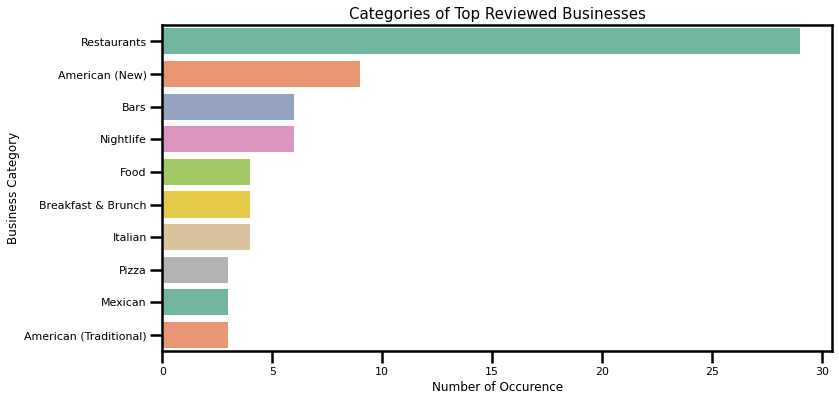

In [6]:
#visualizing the share of each category present in the top 30 reviewed businesses
size = cat_top_rated.nlargest(10,'occurance')['occurance']
label = cat_top_rated.nlargest(10,'occurance')['category']

plt.figure(figsize=(12,6))
sns.barplot(data = cat_top_rated, x = size, y = label, palette = 'Set2')
plt.ylabel('Business Category', fontsize=12)
plt.xlabel('Number of Occurence', fontsize=12)
plt.title('Categories of Top Reviewed Businesses', fontsize=15)
plt.show();

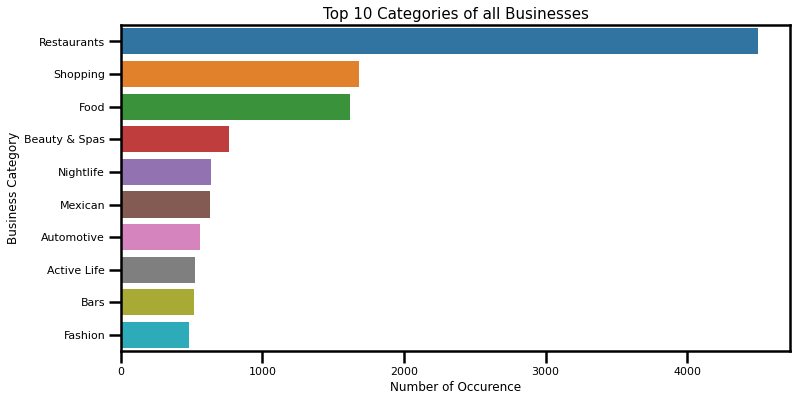

In [7]:
#top 10 occurences of business categories accross the entire dataset

#separating values in categories and saving it to a list, and removing leading and trailing white space
cat_all_list = business.business_categories.str.split(';').sum()
cat_all_list = [x.strip() for x in cat_all_list]

#converting given values to a dictionary
cat_all_dict = {}
for c in range(len(cat_all_list)):
    cat_all_dict[cat_all_list[c]] = cat_all_list.count(cat_all_list[c])

#converting the given dictionary to a DataFrame with all categories
cat_all = pd.DataFrame.from_dict(data = cat_all_dict, orient = 'index')
cat_all.reset_index(inplace = True)
cat_all.columns = ['category', 'occurance']

#visualizing the share of each category present in the whole dataset
size = cat_all.nlargest(10, 'occurance')['occurance']
label = cat_all.nlargest(10, 'occurance')['category']

#creating a barplot
plt.figure(figsize=(12,6))
sns.barplot(data = cat_all, x = size, y = label)
plt.ylabel('Business Category', fontsize=12)
plt.xlabel('Number of Occurence', fontsize=12)
plt.title('Top 10 Categories of all Businesses', fontsize=15)
plt.show();

## 3.3 How often do businesses get reviewed over time?

**Note:** The year 2013 has only reviews for the first 5 days of the year, so this year will not be taken into consideration. Year 2005 contains reviews from March 2005, and it will not be taken into consideration.

Number of reviews per year show a positive linear climb. For the sake of visualization, I picked 4 businesses from the list to analyze the trend of reviews over time. Highly reviewed businesses such as the Phoenix Sky Airport, and Pizzeria Bianco show a positive trend over years. The randomly selected two businesses from the list show a slightly different story: there was a steady positive trend of number of reviews up until the year 2010 and 2011, and the year 2012 recorded a drop in reviews for both establishments.

This steady growth in reviews can potentially show us these businesses value their customer's feedback, and are creating - as well as actively pursuing - a good business environment.

In [8]:
#checking the range of dates
print('Least recent date: ', review['date'].min())
print('Recent date: ', review['date'].max())

Least recent date:  2005-03-07
Recent date:  2013-01-05


**Visualizing Number of reviews per year**

In [9]:
#creating a new column that contains the year of review
review["date"]=  pd.to_datetime(review["date"], format='%Y-%m-%d')
review['year'] = review.date.dt.year

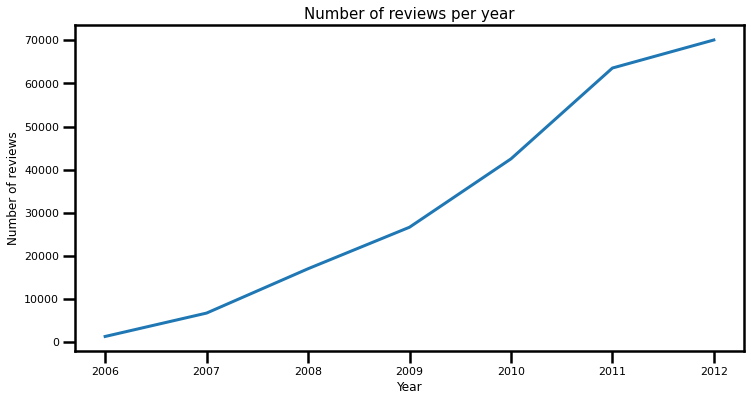

In [10]:
#number of reviews per year not including 2005 and 2013
reviews_per_year = review.groupby(['year']).size().reset_index(name='occurence').drop([0,8])

plt.figure(figsize=(12,6))
sns.lineplot(data = reviews_per_year, x = 'year', y = 'occurence')
plt.ylabel('Number of reviews', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Number of reviews per year', fontsize=15)
plt.show();

**Visualizing Top 10 Businesses with most reviews**

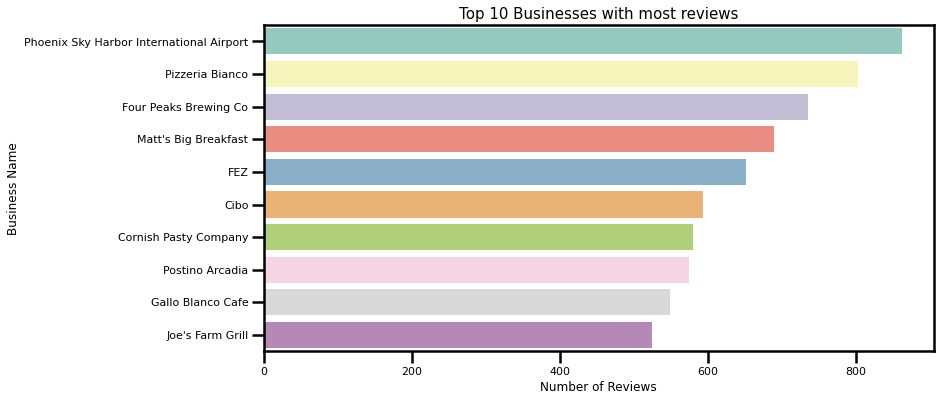

In [11]:
#visualizing top 10 businesses with most rewiews
most_reviewed = business[['business_name', 
                        'business_review_count']].reset_index().sort_values(by='business_review_count', 
                                                                            ascending=False)[:10]

plt.figure(figsize=(12,6))
sns.barplot(data = most_reviewed, x = 'business_review_count', y = 'business_name', palette = 'Set3')
plt.ylabel('Business Name', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)
plt.title('Top 10 Businesses with most reviews', fontsize=15)
plt.show();

**Visualizing frequency of reviews per year for four businesses in the top list**

In [12]:
# Pizzeria Bianco
pizzeria_blanco = review.loc[review['business_name'] == 'Pizzeria Bianco'].sort_values(by = 'year', ascending=False)
pizzeria_blanco_counts = pizzeria_blanco.groupby(['year']).size().reset_index(name='counts').drop([0,8])
pizzeria_blanco_counts = pd.DataFrame(pizzeria_blanco_counts['counts'].values, pizzeria_blanco_counts['year'].values).reset_index()
pizzeria_blanco_counts.rename(columns={"index": "year", 0: "counts"}, inplace = True)

# Postino Arcadia
postino_arcadia = review.loc[review['business_name'] == 'Postino Arcadia'].sort_values(by = 'year', ascending=False)
postino_arcadia_counts = postino_arcadia.groupby(['year']).size().reset_index(name='counts').drop([0,7])
postino_arcadia_counts = pd.DataFrame(postino_arcadia_counts['counts'].values, postino_arcadia_counts['year'].values).reset_index()
postino_arcadia_counts.rename(columns={"index": "year", 0: "counts"}, inplace = True)

#Phoenix Sky Harbor International Airport
phoenix_sky = review.loc[review['business_name'] == 'Phoenix Sky Harbor International Airport'].sort_values(by = 'year', ascending=False)
phoenix_sky_counts = phoenix_sky.groupby(['year']).size().reset_index(name='counts').drop([7])
phoenix_sky_counts = pd.DataFrame(phoenix_sky_counts['counts'].values, phoenix_sky_counts['year'].values).reset_index()
phoenix_sky_counts.rename(columns={"index": "year", 0: "counts"}, inplace = True)

#Joe's Farm Grill
joes_farm = review.loc[review['business_name'] == "Joe's Farm Grill"].sort_values(by = 'year', ascending=False)
joes_farm_counts = joes_farm.groupby(['year']).size().reset_index(name='counts').drop([6])
joes_farm_counts = pd.DataFrame(joes_farm_counts['counts'].values, joes_farm_counts['year'].values).reset_index()
joes_farm_counts.rename(columns={"index": "year", 0: "counts"}, inplace = True)

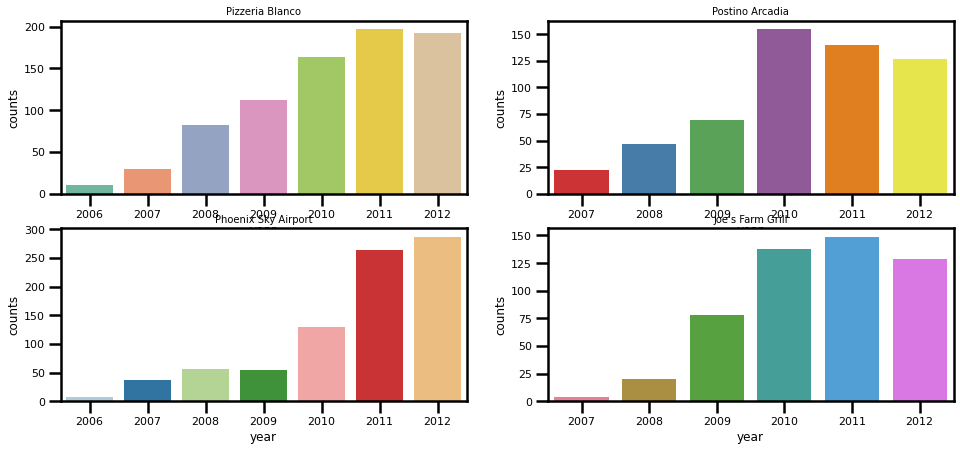

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(16, 7))

sns.barplot(data = pizzeria_blanco_counts, x = 'year', y = 'counts', palette = 'Set2', ax=ax1)
ax1.set_title('Pizzeria Blanco',fontsize=10)

sns.barplot(data = postino_arcadia_counts,x = 'year', y = 'counts', palette = 'Set1', ax=ax2)
ax2.set_title('Postino Arcadia',fontsize=10)

sns.barplot(data = phoenix_sky_counts,x = 'year', y = 'counts', palette = 'Paired', ax=ax3)
ax3.set_title('Phoenix Sky Airport',fontsize=10)

sns.barplot(data = joes_farm_counts,x = 'year', y = 'counts', palette = 'husl', ax=ax4)
ax4.set_title("Joe's Farm Grill",fontsize=10)

plt.show();

## 3.4 How do the categories of trending and top reviewed businesses differ?

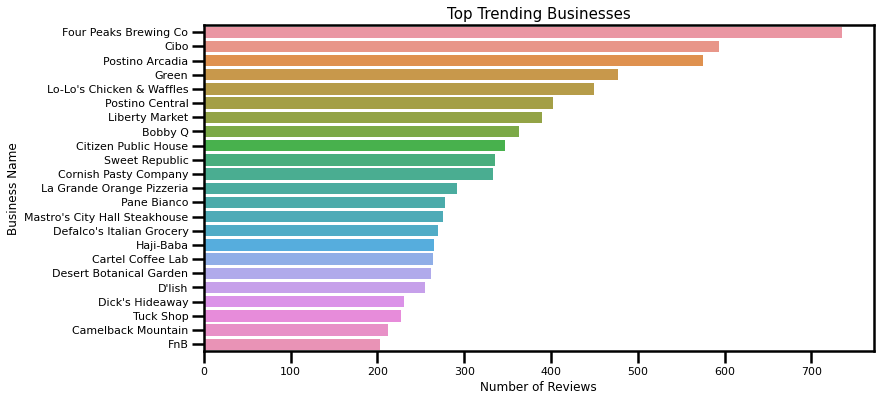

In [14]:
#setting the condition and creating a dataframe of trending businesses
trend_cond = review[(review['year'] >= 2010) & 
                    (review['business_stars'] > 4) & 
                    (review['business_review_count'] > 200)].drop_duplicates(subset = ['business_name'])

top_trending = trend_cond[['business_name', 
                           'business_stars', 
                           'year', 
                           'business_categories',
                          'business_review_count']].sort_values(by = 'business_review_count', ascending = False)

#plot the top trending
plt.figure(figsize=(12,6))
sns.barplot(data = top_trending, x = 'business_review_count', y = 'business_name')
plt.ylabel('Business Name', fontsize=12)
plt.xlabel('Number of Reviews', fontsize=12)
plt.title('Top Trending Businesses', fontsize=15)
plt.show();

In [15]:
#separating values in categories and saving it to a list, and removing leading and trailing white space
cat_top_trend_list = top_trending.business_categories.str.split(';').sum()
cat_top_trend_list = [x.strip() for x in cat_top_trend_list]

#converting given values to a dictionary
cat_top_trend_dict = {}
for c in range(len(cat_top_trend_list)):
    cat_top_trend_dict[cat_top_trend_list[c]] = cat_top_trend_list.count(cat_top_trend_list[c])

#converting the given dictionary to a DataFrame with categories of top trending businesses
cat_top_trend = pd.DataFrame.from_dict(data = cat_top_trend_dict, orient = 'index')
cat_top_trend.reset_index(inplace = True)
cat_top_trend.columns = ['category', 'occurance']
cat_top_trend = cat_top_trend.sort_values(by='occurance', ascending=False).reset_index().drop(columns='index')

In [16]:
#combining categories with >2 occurance in a 'Other' category
cat_top_trend.loc[8] = ['Other Categories', 28]
cat_top_trend = cat_top_trend[(cat_top_trend['occurance']!= 1) & (cat_top_trend['occurance']!= 2)]

In [17]:
cat_top_rated = cat_top_rated.sort_values(by='occurance', ascending=False).reset_index().drop(columns='index')

In [18]:
cat_top_rated = cat_top_rated[(cat_top_rated['occurance']!= 1) & (cat_top_rated['occurance']!= 2)]

In [19]:
cat_top_rated.loc[10] = ['Other Categories', 29]

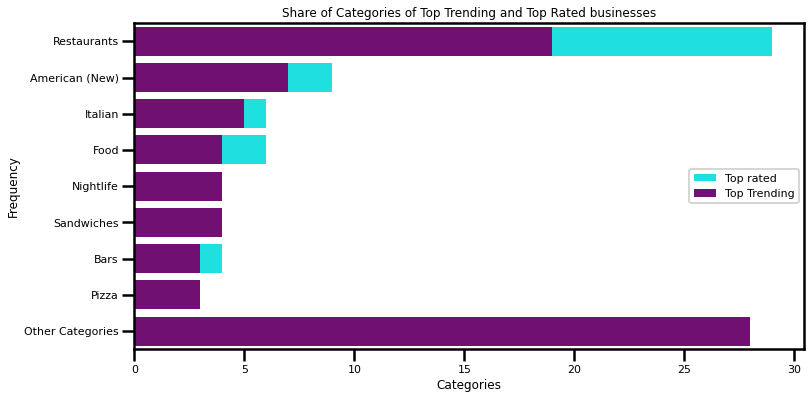

In [20]:
#visualizing categories of top trending and top rated businesses
ax = plt.subplots(figsize=(12,6))
 
ax = sns.barplot(x = cat_top_rated['occurance'], 
                 y = cat_top_rated['category'], 
                 color = 'cyan', label = 'Top rated')
ax = sns.barplot(x = cat_top_trend['occurance'], 
                 y = cat_top_trend['category'], 
                 color = 'purple', label = 'Top Trending')

ax.set(xlabel = 'Categories', ylabel = 'Frequency')
plt.title('Share of Categories of Top Trending and Top Rated businesses')

plt.legend()
plt.show();

## 3.5 Which business categories get bad reviews?

**Note:** For the sake of interpretation only the top 7 categories were chosen for the visualization.

When looking at all categories of businesses that get less than 2 stars per review, the highest number of these reviews, almost 50%, goes to Restaurants, followed by Shopping, and Food. By looking at categories of top 30 businesses with an aggregated business star less than 2, there is no difference in categories, except the presence of the Automotive category. The highest number of bad reviews is US Airways with 95 1-star review, whereas the mean number of 1-star reviews is 43.
Again, this indicates that the dominant category in the dataset is Restaurants, and is most often reviewed.

In [21]:
#filtering bad reviews and creating a dataframe
bad_stars_cond = review[(review['stars'] < 2)].drop_duplicates(subset = ['business_name'])
bad_stars = bad_stars_cond[['business_name','stars','business_categories']]

#separating categories and creating a list, removing leading and trailing white space
bad_reviews_list = bad_stars.business_categories.str.split(';').sum()
bad_reviews_list = [x.strip() for x in bad_reviews_list]

#creating a dictionary from list
bad_reviews_dict = {}
for c in range(len(bad_reviews_list)):
    bad_reviews_dict[bad_reviews_list[c]] = bad_reviews_list.count(bad_reviews_list[c])
    
#creating a dataframe from dictionary
cat_bad_reviews = pd.DataFrame.from_dict(data = bad_reviews_dict, orient = 'index')
cat_bad_reviews.reset_index(inplace = True)
cat_bad_reviews.columns = ['category', 'occurance']
cat_bad_reviews = cat_bad_reviews.sort_values(by='occurance', ascending=False).reset_index().drop(columns='index')

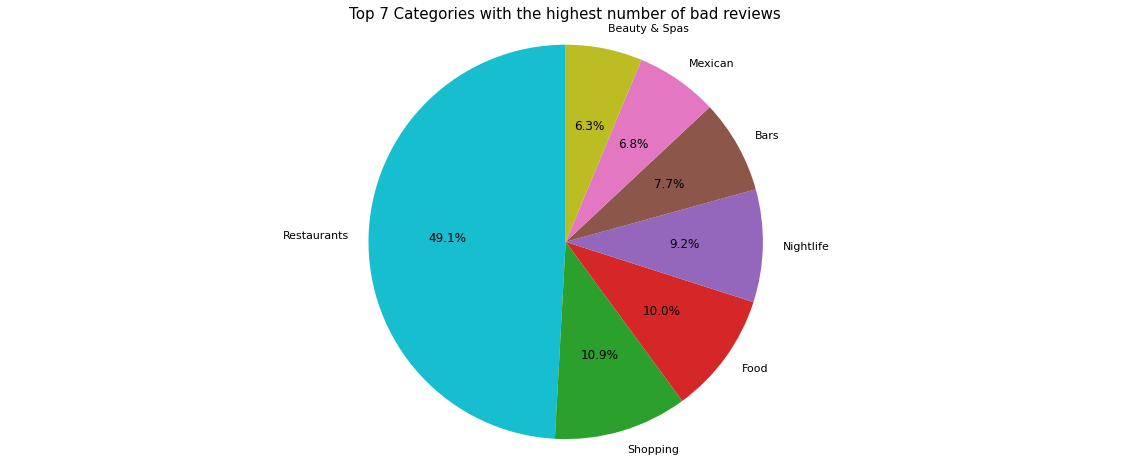

In [22]:
#visualizing categories of bad reviews
size = cat_bad_reviews.nlargest(7, 'occurance')['occurance']
label = cat_bad_reviews.nlargest(7, 'occurance')['category']
cmap = plt.get_cmap("tab10")
colors = cmap(np.array([10, 2, 3, 4, 5, 6, 8]))

fig1, ax1 = plt.subplots(figsize=(20,8))
ax1.pie(size,labels=label, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
plt.title('Top 7 Categories with the highest number of bad reviews', fontsize = 15)
plt.show()

In [23]:
len_occur = []
i = 1

while i < 7:
    occur = len(cat_bad_reviews[cat_bad_reviews['occurance'] == i])
    len_occur.append(occur)
    i += 1

print('Sum of number reviews per category for values 1,2,3,4,5 and 6: ', sum(len_occur))

Sum of number reviews per category for values 1,2,3,4,5 and 6:  237


**Visualizing businesses with the highest number of bad reviews**

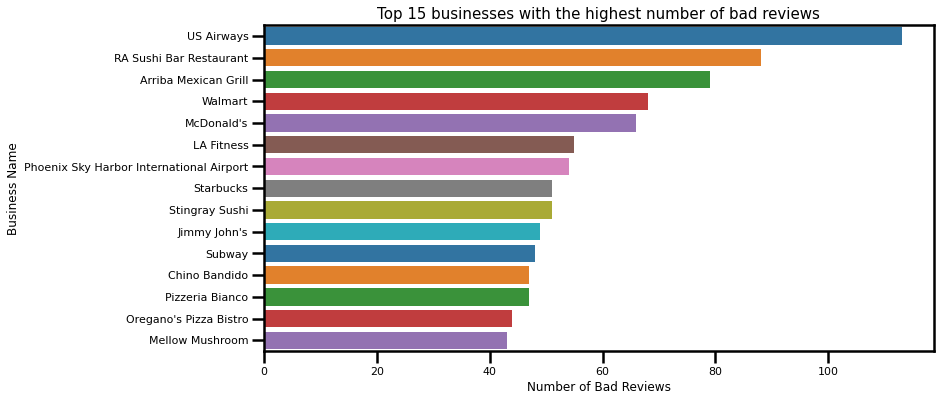

In [24]:
#setting the condition and creating a dataframe of businesses with the highest number of bad reviews
bad_stars_cond = review[review['stars'] < 2]
bad_stars = bad_stars_cond[['business_name','business_categories','stars', 'text']]
bad_stars = bad_stars.business_name.value_counts().reset_index().rename(columns = {'index':'business_name', 'business_name':'count'})
bad_stars = bad_stars.sort_values(by='count', ascending=False)

#visualizing businesses
plt.figure(figsize=(12,6))
sns.barplot(data = bad_stars.nlargest(15,'count'), x = 'count', y = 'business_name', palette = 'tab10')
plt.ylabel('Business Name', fontsize=12)
plt.xlabel('Number of Bad Reviews', fontsize=12)
plt.title('Top 15 businesses with the highest number of bad reviews', fontsize=15)
plt.show();

## 3.6 What are the most common words in bad reviews? 

In [25]:
#creating a dataframe with only 1-star reviews
bad_words_cond = review[review['stars'] == 1]
bad_words = bad_words_cond[['business_name',
                            'stars', 
                            'text', 
                            'business_categories']].reset_index().drop(columns='index')

In [26]:
print('Shape of the dataframe: ', bad_words.shape)

Shape of the dataframe:  (17348, 4)


In [27]:
%%time

#loading in the language model
nlp = spacy.load('en_core_web_sm')

#initializing doc object
doc = list(nlp.pipe(bad_words.text))

CPU times: user 4min 57s, sys: 50.7 s, total: 5min 47s
Wall time: 5min 48s


In [28]:
#extract all the properties of each word
def extract_tokens(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc.
    This function will iterate over the tokens in a single doc 
    and will extract various attributes such as the lemma, pos, entity and tag."""
    
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc]

#define a function to apply the function above to all documents and store the outputs in a Pandas dataframe .
def df_tokens(doc):
    """Extract tokens and metadata from list of spaCy docs.
    Function to apply the function above to all documents 
    and store the outputs in a Pandas dataframe ."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, d in enumerate(doc):
        meta = extract_tokens(d)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)  

In [29]:
clean_doc = df_tokens(doc)
clean_doc.head()

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
0,0,U,0,u,,PRP,nsubj,PRON,False,True,False,False
1,0,can,1,can,,MD,aux,AUX,True,True,False,False
2,0,go,2,go,,VB,ROOT,VERB,True,True,False,False
3,0,there,3,there,,RB,advmod,ADV,True,True,False,False
4,0,n,4,n,,CC,cc,CCONJ,False,True,False,False


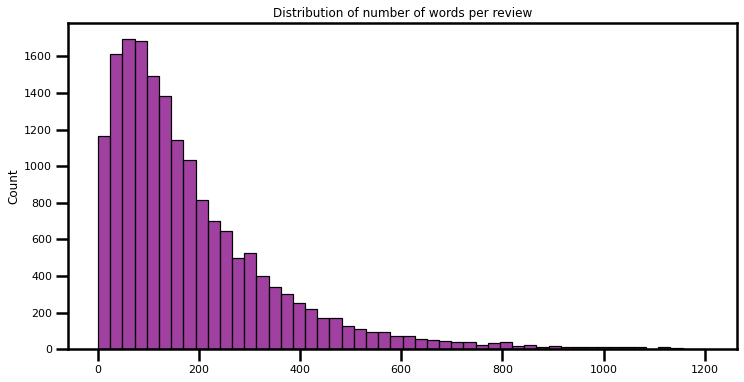

In [30]:
#visualizing distribution of number of words per doc

plt.figure(figsize=(12,6))
sns.histplot(clean_doc.groupby("doc_id").size(), bins = 50, color = 'purple')
plt.title('Distribution of number of words per review', fontsize = 12)
plt.show();

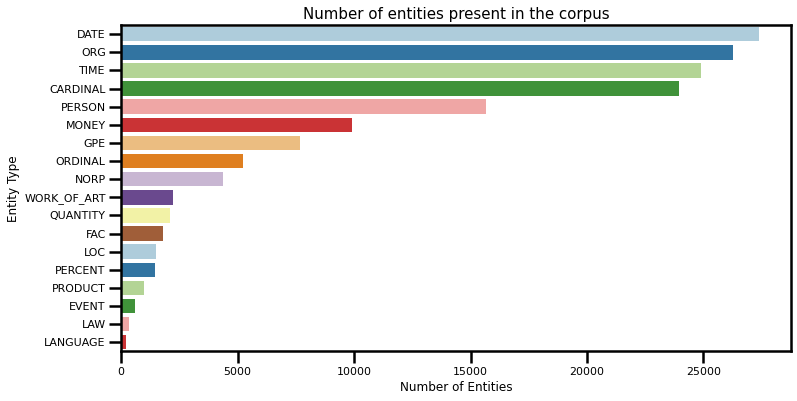

In [31]:
#counting frequency of entity types and visualizing it
freq_ent = clean_doc.query("ent_type != ''").ent_type.value_counts().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data = freq_ent, x = 'ent_type', y = 'index', palette = 'Paired')
plt.ylabel('Entity Type', fontsize=12)
plt.xlabel('Number of Entities', fontsize=12)
plt.title('Number of entities present in the corpus', fontsize=15)
plt.show();

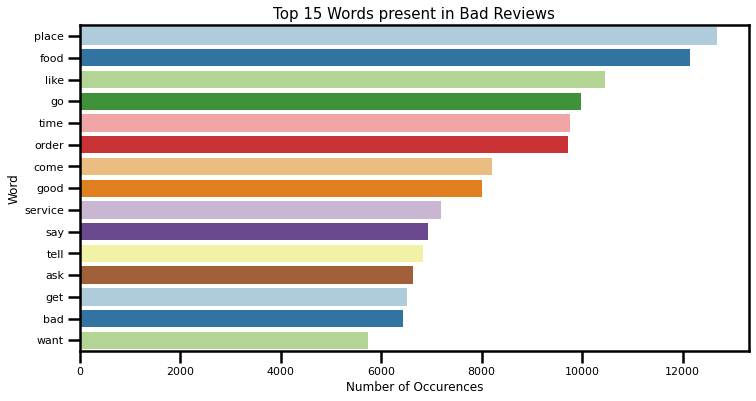

In [32]:
#counting top 15 words in the corpus
top_bad_words = clean_doc.query("is_stop == False & is_punct == False").lemma.value_counts().head(19).reset_index()
top_bad_words = top_bad_words.drop([0, 1, 10, 17])

plt.figure(figsize=(12,6))
sns.barplot(data = top_bad_words, x = 'lemma', y = 'index', palette = 'Paired')
plt.ylabel('Word', fontsize=12)
plt.xlabel('Number of Occurences', fontsize=12)
plt.title('Top 15 Words present in Bad Reviews', fontsize=15)
plt.show();